In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.image import crop_to_bounding_box
from tensorflow import keras
from keras import layers
from keras.callbacks import *
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, r2_score

# 2. Cropping Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batchSize = 32
imageHeight = 180
imageWidth = 180
randomisingSeed = 123
colorMode = "grayscale"
validationSplitFraction = 0.2
imageInterpolationMethod  = "bilinear"
cropToPreserveAspectRatioWhileResizing = False
augmentDataset = True

cropBottomPanel = True

In [ ]:
datasetName = 'SEM100'
trainingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/train'
testingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/test'

In [ ]:
def getDataset(batchSize, imageHeight, imageWidth, randomisingSeed, colorMode, validationSplitFraction, imageInterpolationMethod, cropToPreserveAspectRatioWhileResizing, augmentDataset, cropBottomPanel):
  trainingDataset, validationDataset = tf.keras.utils.image_dataset_from_directory(
      directory = trainingDataPath,
      labels = "inferred",
      label_mode = "categorical",
      color_mode = colorMode,
      batch_size = batchSize,
      image_size = (imageHeight, imageWidth),
      seed = randomisingSeed,
      shuffle = True,
      validation_split = validationSplitFraction,
      subset="both",
      interpolation = imageInterpolationMethod,
      crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
      )

  testingDataset = tf.keras.utils.image_dataset_from_directory(
    directory = testingDataPath,
    labels = 'inferred',
    label_mode = "categorical",
    color_mode = colorMode,
    batch_size = batchSize,
    image_size = (imageHeight, imageWidth),
    seed=  randomisingSeed,
    shuffle = True,
    interpolation = imageInterpolationMethod,
    crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
    )

  classNames = np.array(trainingDataset.class_names)
  print(classNames)

  def cropBottomPanel(image, label):
    return tf.image.crop_to_bounding_box(image, offset_height = 0, offset_width = 0, target_height = int(imageHeight * 600/ 768), target_width = imageWidth), label



  if cropBottomPanel:
    trainingDataset = trainingDataset.map(cropBottomPanel)
    validationDataset = validationDataset.map(cropBottomPanel)

  AUTOTUNE = tf.data.AUTOTUNE
  trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

  return trainingDataset, validationDataset, testingDataset, classNames

In [ ]:
def visualiseDataset(dataset, noOfRows, noOfColumns):
  plt.figure(figsize=(noOfRows*2.5, noOfColumns*2.5))

  for images, labels in dataset.take(1):
    for i in range(noOfRows * noOfColumns):
      ax = plt.subplot(noOfRows, noOfColumns, i + 1)

      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(classNames[ np.argmax(labels[i]) ])

      plt.axis("off")

In [ ]:
print(trainingDataset)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 140, 180, 1), dtype=tf.float32, name=None)>


In [ ]:
trainingDataset, validationDataset, testingDataset, classNames = getDataset(batchSize = batchSize,
                                                                                                      imageHeight = imageHeight, imageWidth = imageWidth,
                                                                                                      randomisingSeed = randomisingSeed,
                                                                                                      colorMode = colorMode,
                                                                                                      validationSplitFraction = validationSplitFraction,
                                                                                                      imageInterpolationMethod = imageInterpolationMethod,
                                                                                                      cropToPreserveAspectRatioWhileResizing = cropToPreserveAspectRatioWhileResizing,
                                                                                                      augmentDataset = augmentDataset, cropBottomPanel = cropBottomPanel)

Found 1223 files belonging to 10 classes.
Using 979 files for training.
Using 244 files for validation.
Found 319 files belonging to 10 classes.
['Biological' 'Fibres' 'Films_Coated_Surface'
 'MEMS_devices_and_electrodes' 'Nanowires' 'Particles' 'Patterned_surface'
 'Porous_Sponge' 'Powder' 'Tips']


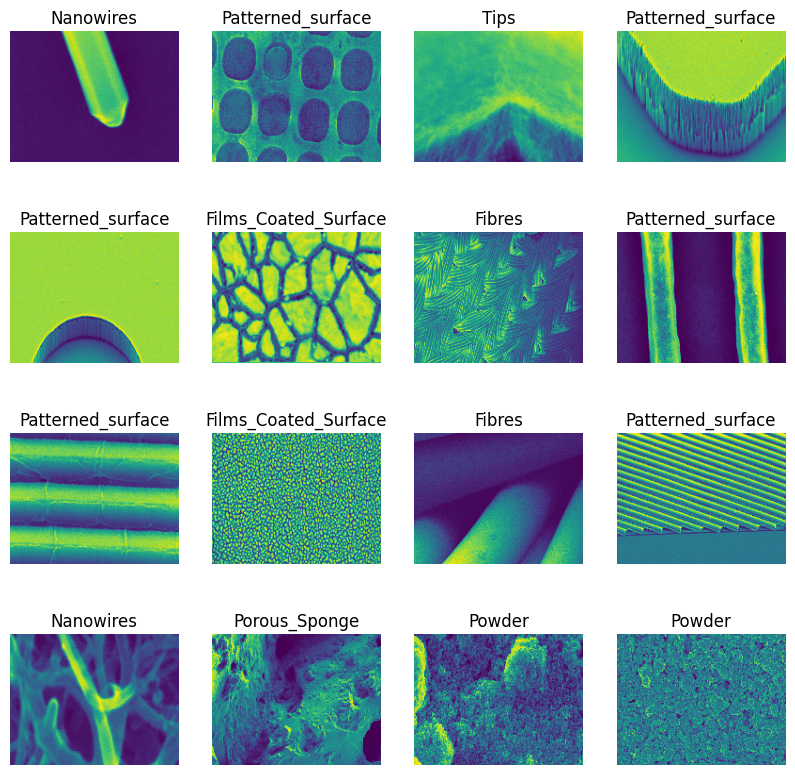

In [ ]:
visualiseDataset(trainingDataset, 4, 4)

# 1. Callback Testing

In [ ]:
X = np.linspace(0, 100, 100)
y = np.linspace(0, 100, 100) + np.random.normal(loc=1.0, scale=20.0, size=(100,))

In [ ]:
print(X.shape)
print(y.shape)

(100,)
(100,)


In [ ]:
bestModelCheckpoint = ModelCheckpoint('/content/bestModel.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False,
    mode= 'auto', save_freq='epoch', options = None, initial_value_threshold=None)
allModelsCheckpoint = ModelCheckpoint('/content/modelEpoch{epoch:03d}.h5', monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False,
    mode= 'auto', save_freq='epoch', options = None, initial_value_threshold=None)

In [ ]:
callbacks = [bestModelCheckpoint, allModelsCheckpoint]

In [ ]:
model = Sequential()
model.add(layers.Dense(5, activation='relu', input_shape = (1,)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', r2_score], run_eagerly=True)

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 5)                 10        
                                                                 
 dense_33 (Dense)            (None, 5)                 30        
                                                                 
 dense_34 (Dense)            (None, 1)                 6         
                                                                 
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, validation_split= 0.2, epochs=100, verbose=1, callbacks =callbacks)

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 413.2706 - mse: 413.2706 - r2_score: 0.5489
Epoch 1: val_loss did not improve from 600.14594

Epoch 1: saving model to /content/modelEpoch001.h5
3/3 [==============================] - 0s 119ms/step - loss: 413.2706 - mse: 413.2706 - r2_score: 0.5489 - val_loss: 666.5280 - val_mse: 666.5280 - val_r2_score: -0.2174
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 413.1396 - mse: 413.1396 - r2_score: 0.4115
Epoch 2: val_loss did not improve from 600.14594

Epoch 2: saving model to /content/modelEpoch002.h5
3/3 [==============================] - 0s 107ms/step - loss: 413.1396 - mse: 413.1396 - r2_score: 0.4115 - val_loss: 662.1158 - val_mse: 662.1158 - val_r2_score: -0.2094
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 412.0198 - mse: 412.0198 - r2_score: 0.4972
Epoch 3: val_loss did not improve from 600.14594

Epoch 3: saving model to /content/modelEpoch003.h5
3/3 [===================

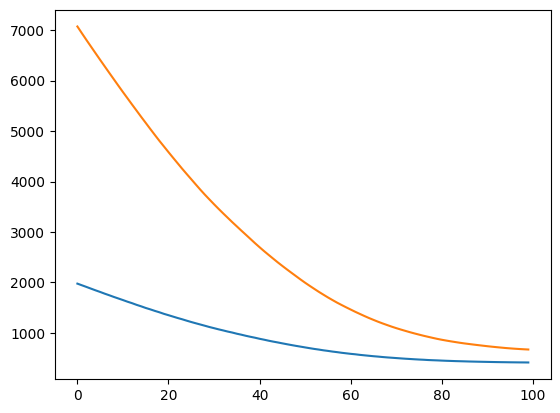

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

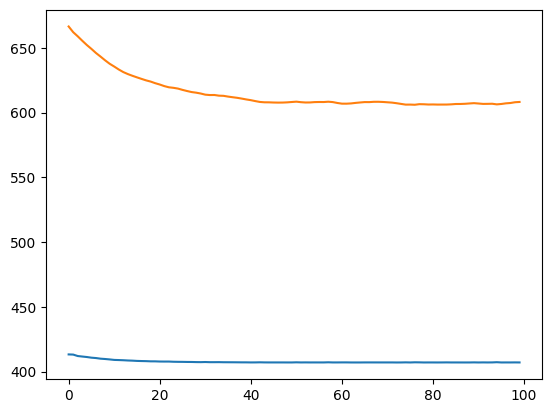

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

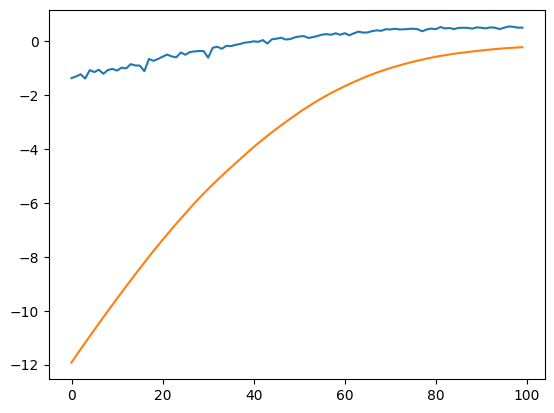

In [ ]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])

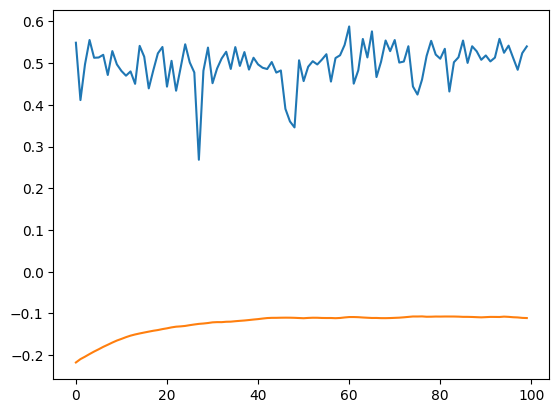

In [ ]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])

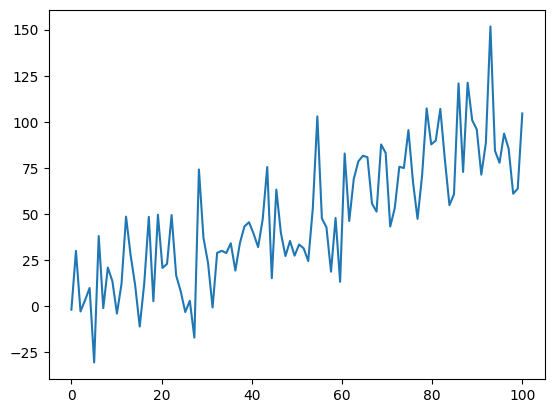

In [ ]:
plt.plot(X, y)

4/4 [==============================] - 0s 3ms/step


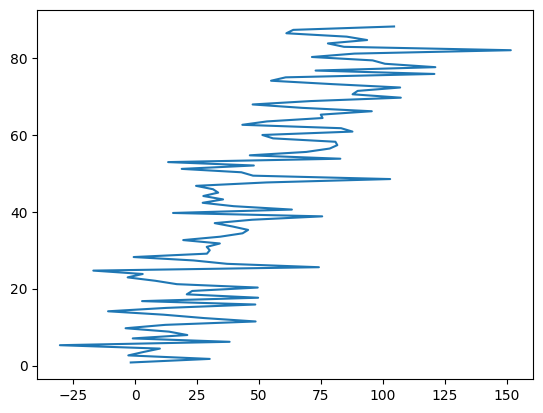

In [ ]:
plt.plot(y, model.predict(X))

4/4 [==============================] - 0s 4ms/step


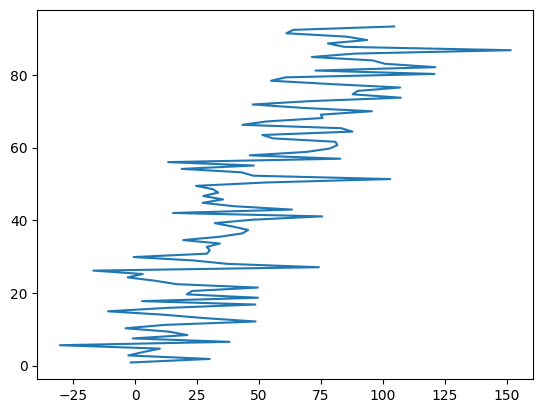

In [ ]:
plt.plot(y, model.predict(X))